## INLÄMNING DEL 1

# Bearbeta data
- Läser in data från csv-fil
- Kontrollerar dataset
- Konverterar nödvändiga datatyper till rätt typ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import norm, ttest_ind, t as t_dist
import io
from contextlib import redirect_stdout
#import seaborn as sns

pd.options.display.float_format = "{:.2f}".format

# Välj Seaborn-tema
#sns.set_theme(style="whitegrid")

#Load dataset
df = pd.read_csv("data/health_study_dataset.csv")

#Clean whitespace from necessary columns and convert to categorical
pattern = r"^\s|\s$"
cat_cols = ["sex", "smoker"]

for col in cat_cols:
    if df[col].astype(str).str.contains(pattern, regex=True, na=False).any():
        print(f"{col}: whitespace detected - cleaning")
        df[col] = df[col].astype(str).str.strip()
    else:
        print(f"{col}: clean")
    df[col] = df[col].astype("category")


#Convert disease column to boolean if it only contains 0 and 1
if set(df["disease"].unique()) <= {0, 1}:
    df["disease"] = df["disease"].astype(bool)
    print("Kolumnen 'disease' innehåller endast 0 och 1 - konverterad till bool.")
else:
    print("Kolumnen 'disease' innehåller andra värden - ingen konvertering gjord.")

print(df.dtypes)

#Control unique IDs and remove duplicates
unique_ids = df["id"].nunique()
total_rows = len(df)

if unique_ids < total_rows:
    print(f" Dubbletter hittades baserat på 'id': {total_rows - unique_ids} st")
    df = df.drop_duplicates(subset="id")
    print(f" Dubbletter borttagna. Ny datastorlek: {len(df)} rader")
else:
    print("Alla ID är unika - inga dubbletter hittades.")


sex: clean
smoker: clean
Kolumnen 'disease' innehåller endast 0 och 1 - konverterad till bool.
id                int64
age               int64
sex            category
height          float64
weight          float64
systolic_bp     float64
cholesterol     float64
smoker         category
disease            bool
dtype: object
Alla ID är unika - inga dubbletter hittades.


### Datakontroll och förbehandling

En kvalitetskontroll genomfördes av datasetet.  
- Kolumnerna `sex` och `smoker` har kontrollerats och konverterats till kategoriska variabler.
- Kolumnen `disease` bestod endast av värdena 0 och 1 och konverterades därför till en boolesk variabel.  
- Kontroll av `id` visade att samtliga observationer är unika, vilket innebär att inga dubbletter förekommer.  

Datasetet är därmed välstrukturerat och lämpligt för vidare analys.

# Beskrivande analys

              mean  median   std    min    max
age          49.43   50.00 14.50  18.00  90.00
height      171.85  171.35  9.80 144.40 200.40
weight       73.41   73.20 13.69  33.70 114.40
systolic_bp 149.18  149.40 12.79 106.80 185.90
cholesterol   4.93    4.97  0.85   2.50   7.88


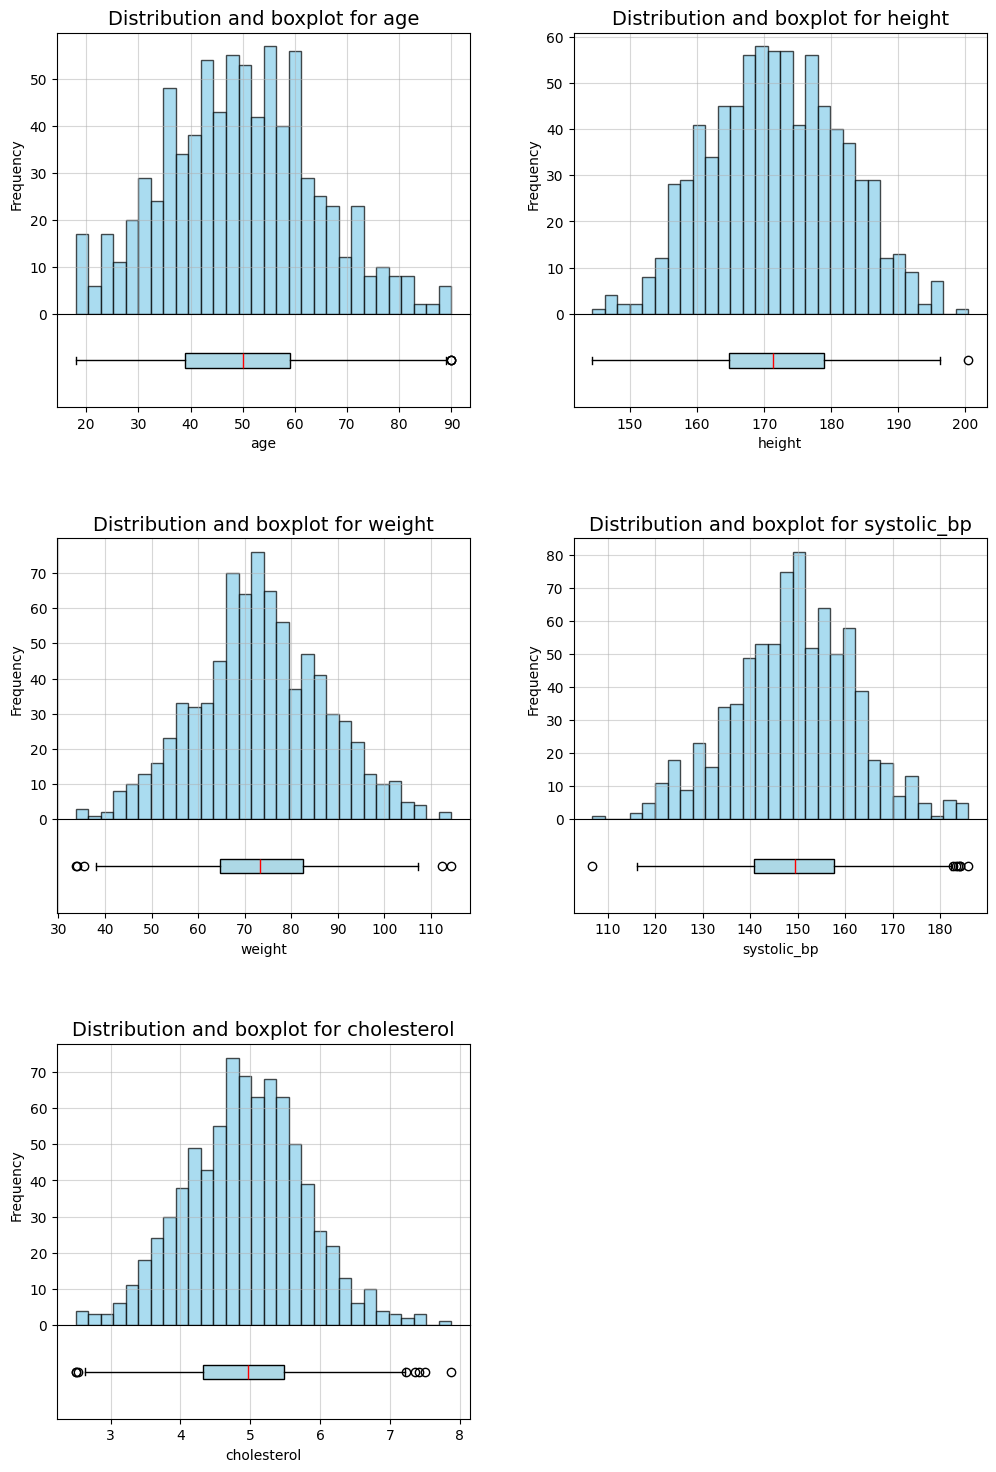

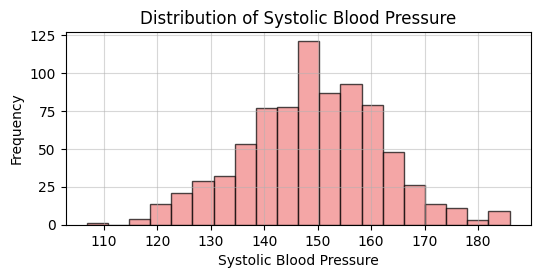

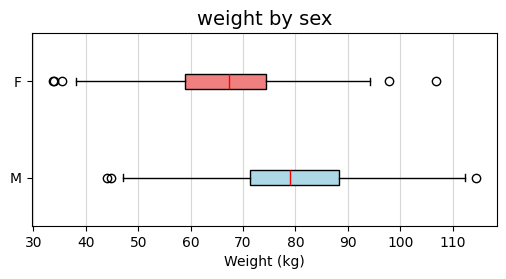

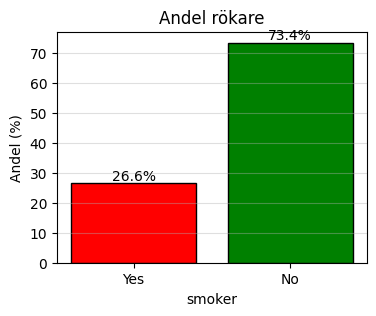

In [2]:
#Calculate summary statistics for numerical columns
num_cols = ["age", "height", "weight", "systolic_bp", "cholesterol"]

summary = df[num_cols].agg(["mean", "median", "std", "min", "max"]).T
print(summary)

#Function for visualization of numerical variable distributions
def plot_hist(data, col, ax, bins=30, color="skyblue"):
    """
    Draw a histogram for a column.
    """
    ax.hist(data, bins=bins, color=color, edgecolor="black", alpha=0.7)
    ax.set_title(f"Distribution of {col}", fontsize=12)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.grid(axis="both", alpha=0.5)


def plot_box(data, col, ax, color="lightblue", position=1):
    """
    Draw a boxplot for a column.
    """
    kwargs = dict(
        vert=False, patch_artist=True,
        boxprops=dict(facecolor=color, color="black"),
        medianprops=dict(color="red")
    )
    if position is not None:
        kwargs["positions"] = [position]   # <-- placera på vald rad
    
    ax.boxplot(data, **kwargs)
    ax.set_xlabel(col)
    #ax.set_title(f"Boxplot of {col}", fontsize=12)
    ax.set_yticks([]) #tilladga
    ax.set_ylabel("") #tillagda
    ax.grid(axis="x", alpha=0.5)


def plot_group_box(df, value_col, group_col, ax,
                   order=None, colors=None, title=None):
    """
    Draw boxplots for value_col grouped by group_col on the same axis.
    Uses the plot_box function and positions.
    """

    # Determine group order
    groups = list(df[group_col].dropna().unique()) if order is None else order

    # Default colors (M blue, F pink
    default_colors = {"M": "lightblue", "F": "lightcoral"} 

    # Loop and draw a box for each group at different positions
    plotted = []  # keeps track of which groups were actually plotted

    for pos, group in enumerate(groups, start=1):
        data = df.loc[df[group_col] == group, value_col].dropna()
        if data.empty:
            continue
        color = default_colors.get(group, "lightgray") if colors is None else colors.get(group, "lightgray")
        plot_box(data, value_col, ax, color=color, position=pos)
        plotted.append((pos, group))
    
    # Y-axis labels
    if plotted:                      # if at least one group was plotted
        positions, labels = zip(*plotted)
        ax.set_yticks(positions)
        ax.set_yticklabels(labels)
    else:                               # if no groups were plotted (all empty)
        ax.set_yticks([])

    # Title
    if title is None:
        ax.set_title(f"{value_col} by {group_col}", fontsize=14)
    else:
        ax.set_title(title, fontsize=14)


def plot_proportion_bar(df, col, ax, title=None, colors=None, order=None):
    """
    Draw a bar chart of proportions (%) for a categorical variable.
    
    Parameters:
        df : DataFrame
        col : column name (categorical variable)
        ax : matplotlib axis to draw on
        title : (optional) figure title
        colors : (optional) list or dict for colors
        order : (optional) order of categories
    """

    # Calculate proportions (%)
    prop = df[col].value_counts(normalize=True) * 100

    if order is not None:
        prop = prop.reindex(order)
        prop = prop.fillna(0)   

    #If colors is a dictionary, select colors in the correct order; if none specified, use default
        bar_colors = [colors.get(category, "lightgray") for category in prop.index]
    else:
        bar_colors = colors if colors is not None else "lightblue"

    # Draw bar chart
    ax.bar(prop.index, prop.values, color=bar_colors, edgecolor="black")

    # Labels
    ax.set_ylabel("Andel (%)")
    ax.set_xlabel(col)
    ax.set_title(title or f"Andel per kategori i {col}")
    ax.grid(axis="y", alpha=0.4)

    # Show percentage values above bars
    for i, v in enumerate(prop.values):
        ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=10)



# Layout (Set up grid for plots)
n_cols = 2 #fixed number of columns
n_rows = int(np.ceil(len(num_cols) / n_cols)) #calculate number of rows needed

fig = plt.figure(figsize=(12, 6 * n_rows))

# Outer grid controls spacing between variable pairs
outer = fig.add_gridspec(n_rows, n_cols, hspace=0.35, wspace=0.25)

for i, col in enumerate(num_cols):
    row_gr = i // n_cols       # row index (for histogram)
    c = i % n_cols  # kocolumn index

    # Inner grid = histogram + boxplot, completely without spacing
    inner = outer[row_gr, c].subgridspec(2, 1, height_ratios=[3, 1], hspace=0.0) # skapar 2 rader, 1 kolumn som fördelar sig 75% överst och 25% nederst

    # Draw plots
    ax_hist = fig.add_subplot(inner[0])
    ax_box  = fig.add_subplot(inner[1], sharex=ax_hist)
   
    # Rita grafer
    plot_hist(df[col].dropna(), col, ax_hist)
    plot_box(df[col].dropna(), col, ax_box)

    # Remove x-axis labels/ticks on the histogram (top), needs to be done after plotting    
    ax_hist.tick_params(axis="x", which="both", labelbottom=False, bottom=False)
    #ax_hist.set_xlabel("")  # remove any x-label
    ax_hist.spines["bottom"].set_visible(False)

    # Shared title
    ax_hist.set_title(f"Distribution and boxplot for {col}", fontsize=14)
plt.show()

# Histogram of blood pressure
fig, ax = plt.subplots(figsize=(6, 2.5))
plot_hist(
    df["systolic_bp"].dropna(),
    "Systolic Blood Pressure",
    ax,
    bins=20,
    color="lightcoral"
)

# Boxplot of weight by sex
fig, ax = plt.subplots(figsize=(6, 2.5))
plot_group_box(df, "weight", "sex", ax=ax, order=["M", "F"])
ax.set_xlabel("Weight (kg)")   # change x-label

plt.show()

# Bar chart of the proportion of smokers and non-smokers
fig, ax = plt.subplots(figsize=(4, 3))
plot_proportion_bar(df, "smoker", ax, 
                    title="Andel rökare", 
                    colors={"Yes": "red", "No": "green"},
                    order=["Yes", "No"]
                    )
plt.show()


# Simulering kopplad till caset



In [3]:
# Funktion för att 
def ci_prop_normal(prop: float, n: int, level: float = 0.95, clip: bool = True):
    """
    100*level % konfidensintervall för en proportion p med normalapproximation.
    p = andel (t.ex. real_prop), n = urvalsstorlek.
    """
    alpha = 1 - level
    z = norm.ppf(1 - alpha/2)        # t.ex. 1.96 för 95%, 2.576 för 99%
    sd = np.sqrt(prop * (1 - prop) / n)
    lo, hi = prop - z*sd, prop + z*sd
    if clip: # Klipper intervallet till [0,1] då andel inte kan vara negativt
        lo, hi = max(0.0, lo), min(1.0, hi)
    return lo, hi, sd, z


# Proportion of people with disease in the real dataset
real_prop = (df["disease"] == True).mean()


# Simulation with the same proportion
np.random.seed(42)
n=1000
simulated = np.random.rand(n) < real_prop #Create a list with True and False values similar to real_prop
#simulated = np.random.choice([True, False], size=1000, p=[real_prop, 1-real_prop]) # same but slower
sim_prop = (simulated == True).mean()

# Välj konfidensnivå
level = 0.95

ci_low, ci_high, sd, z = ci_prop_normal(real_prop, n=n, level=level)

print(f"Andel i data: {real_prop*100:.2f}%")
print(f"Andel i simulering: {sim_prop*100:.2f}%")
print(f"{int(level*100)}% CI (normalapprox) för verklig andel: [{ci_low*100:.2f}%, {ci_high*100:.2f}%]")
#print(f"z = {z:.3f}, SD = {sd*100:.2f}%")
print("Ligger simulerad andel inom bandet?",
      "Ja" if ci_low <= sim_prop <= ci_high else "Nej")


# print(f"Andel med sjukdom i datasetet: {real_prop*100:.1f}%")

# print(f"Andel sjukdom i simuleringen: {sim_prop*100:.1f}%")

# #Comparison
# print(f"Skillnad: {(sim_prop - real_prop)*100:.1f}%")

Andel i data: 5.88%
Andel i simulering: 6.30%
95% CI (normalapprox) för verklig andel: [4.42%, 7.33%]
Ligger simulerad andel inom bandet? Ja


### Tolkning av simulering:
 
 Eftersom urvalet är stort (n = 1000) och andelen med sjukdom (≈ 6 %) inte är extrem, är normalapproximationen giltig. Den simulerade andelen (6,30 %) ligger inom 95 %-intervallet kring den observerade andelen (5,88 %), vilket är förenligt med slumpvariation. Det innebär att simuleringen återspeglar den observerade andelen väl, och att ingen systematisk skillnad mellan data och simulering kan påvisas.

## Konfidensintervall

In [4]:
# Confidence interval using normal approximation
def ci_norm(series, confidence = 0.95):
    # Validering
    if not (0 < confidence < 1):
        raise ValueError("confidence måste ligga mellan 0 och 1.")
    
    x = np.asarray(series, dtype=float)
    x = x[~np.isnan(x)]
    n=len(x)
    if n == 0:
        raise ValueError("Ingen data kvar efter dropna().")
    
    mean = x.mean()
    std = x.std(ddof=1)
    
    alpha=1-confidence
    # z-value for the chosen confidence level
    z = norm.ppf(1 - alpha/2)

    se = std/np.sqrt(n) #standard error

    
    ci_lower = mean - z*se
    ci_upper = mean + z*se

    level = int(round(confidence*100))

    return  float(mean), (float(ci_lower), float(ci_upper)), level  


# Confidence interval using bootstrap Percentile CI

def ci_mean_boot_perc(series, confidence=0.95, n_boot=20_000, random_state=42):
    # Validation
    if not (0 < confidence < 1):
        raise ValueError("Confidence must be between 0 and 1.")
    
    x = np.asarray(series, dtype=float)
    x = x[~np.isnan(x)]
    n = len(x)
    if n == 0:
        raise ValueError("No data remaining after dropna().")
    
    mean_x = float(x.mean())
    rng = np.random.default_rng(random_state)

    # Ver1 Bootstrap Means via Index Sampling
    idx = rng.integers(0, n, size=(n_boot,n))
    boot_mean = x[idx].mean(axis=1)

    # Ver 2. LOOP: Create one resample at a time
    # boot_mean = np.empty(n_boot,dtype=float)

    # for i in range(n_boot):
    #     boot_sample = rng.choice(x, size=n, replace=True)
    #     boot_mean[i] = boot_sample.mean()

    alpha = 1 - confidence
    lo = float(np.quantile(boot_mean, alpha/2)) # At alpha = 0.5, 2.5% of the bootstrap means lie below lo
    hi = float(np.quantile(boot_mean, 1-alpha/2)) #See above, the threshold below which 97.5% lie at alpha = 0.5

    level = int(round(confidence*100))

    return mean_x, (lo, hi), level #boot_mean
   
# Confidence interval using bootstrap BCa
def ci_mean_boot_bca(series, confidence=0.95, n_boot=20_000, random_state=42):
    # Validation
    if not (0 < confidence < 1):
        raise ValueError("Confidence must be between 0 and 1.")
    
    x = np.asarray(series, dtype=float)
    x = x[~np.isnan(x)]
    n = len(x)
    if n == 0:
        raise ValueError("No data remaining after dropna().")
    
    mean_x = float(x.mean())
    rng = np.random.default_rng(random_state)

    # Bootstrap with resampling with replacement
    idx = rng.integers(0, n, size=(n_boot,n))
    boot_mean = x[idx].mean(axis=1)

    # Bootstrap correction (z0)
    # Proportion of bootstrap means < observed mean
    prop = (boot_mean < mean_x).mean() #If not 0.5, the bootstrap distribution is shifted (bias)
    z0 = norm.ppf(prop) #Correction factor, transformed into a z-value

    # Acceleration(a) — adjusts for skewness, based on the jackknife 
    sumx = x.sum()
    loo_means = (sumx - x) / (n - 1)  # LOO-mean: the mean when each observation is left out in turn
    jack_mean = loo_means.mean() #Average of LOO-means

    num = np.sum((jack_mean - loo_means)**3)
    den = 6 * (np.sum((jack_mean - loo_means)**2))**1.5
    a = num/den if den != 0 else 0.0 # If 0, there is no skewness correction

    #BCa quantile adjustment
    alpha = 1 - confidence

    def bca_quantile(p):
        z = norm.ppf(p)
        adj = z0 + (z0 + z) / (1 - a * (z0 + z))   # BCa transformation
        return float(np.quantile(boot_mean, norm.cdf(adj)))

    lo = bca_quantile(alpha/2)
    hi = bca_quantile(1 - alpha/2)

    level = int(round(confidence*100))

    return mean_x, (lo, hi), level #boot_mean


mean_n, (ci_lo_n, ci_hi_n), level_n = ci_norm(df["systolic_bp"], 0.95)
mean_bp, (ci_lo_bp, ci_hi_bp), level_bp = ci_mean_boot_perc(df["systolic_bp"], 0.95)
mean_bbca, (ci_lo_bbca, ci_hi_bbca), level_bbca = ci_mean_boot_bca(df["systolic_bp"], 0.95)

rows = [
    {"Metod": "Normalapproximation", "Medel": mean_n, "KI nedre": ci_lo_n, "KI övre": ci_hi_n, "Nivå (%)": level_n},
    {"Metod": "Bootstrap (percentil)", "Medel": mean_bp, "KI nedre": ci_lo_bp, "KI övre": ci_hi_bp, "Nivå (%)": level_bp},
    {"Metod": "Bootstrap (BCa)", "Medel": mean_bbca, "KI nedre": ci_lo_bbca, "KI övre": ci_hi_bbca, "Nivå (%)": level_bbca},
]
ci_df = pd.DataFrame(rows)
display(ci_df.style.format({"Medel": "{:.2f}", "KI nedre": "{:.2f}", "KI övre": "{:.2f}"}))


,Metod,Medel,KI nedre,KI övre,Nivå (%)
0,Normalapproximation,149.18,148.29,150.07,95
1,Bootstrap (percentil),149.18,148.30,150.07,95
2,Bootstrap (BCa),149.18,148.29,150.06,95


### Tolkning av skattning av konfidensintervall för Systolisk blodtryck
Resultaten från de tre metoderna visar liknande 95 %-konfidensintervall för medelvärdet av systoliskt blodtryck, vilket tyder på en stabil skattning som inte är känslig för metodval.

Normalapproximationen fungerar väl då urvalet är stort och blodtrycket är ungefär normalfördelat (se figur "Distribution of systolic blood pressure" ).

Bootstrapmetoderna ger en icke-parametrisk kontroll, där BCa justerar för eventuell skevhet. De överlappande intervallen antyder att skillnaderna främst beror på slumpvariation.

## Test hur bra CI-metoderna för konfidensintervall är

In [5]:
# Test the CI-methods
def covers_true_mean(series, method="normal", n=40, trials=200, confidence=0.95, n_boot=20_000, random_state=42):
    """
    Calculates the coverage for a given CI method.

    Args:
        series: Data to analyze (pd.Series or array)
        method: Which CI method to use ('normal', 'bootstrap', or 'bca')
        n: Sample size for each simulation
        trials: Number of simulations to run
        confidence: Confidence level (e.g., 0.95 for 95% CI)
        random_state: Random seed for reproducibility

    Returns:
        Dict with the method's performance:
        - coverage: Proportion of intervals that contain the population mean
        - avg_width: Average interval width
        - std_width: Standard deviation of the interval widths
    """
    x = np.asarray(series, dtype=float)
    x = x[~np.isnan(x)]
    true_mean = float(x.mean())
    rng = np.random.default_rng(random_state)

    hits = 0 # Counter for number of hits (intervals that cover true_mean)
    widths = [] # Collecting interval widths

    # Select CI method
    func_map = {
        "normal": ci_norm,
        "bootstrap": ci_mean_boot_perc,
        "bca": ci_mean_boot_bca
    }
    ci_func = func_map.get(method)
    if ci_func is None:
        raise ValueError(f"Unknown method: {method}")
    

    # Run simulations
    for _ in range(trials):
        sample = rng.choice(x, size=n, replace=True)
        
        # Calculate CI (suppress any output)
        f = io.StringIO()
        with redirect_stdout(f):
            # Pass bootstrap parameters for the bootstrap methods
            if method in ["bootstrap", "bca"]:
                out = ci_func(sample, confidence, n_boot=n_boot, random_state=random_state)
            else:
                out = ci_func(sample, confidence)
        
        # Unpack the result
        _, (lo, hi), *rest = out if isinstance(out, tuple) else (out, (np.nan, np.nan))
        
        #Update statistics
        hits += (lo <= true_mean <= hi)
        widths.append(hi - lo)
    
    return {
        'method': method,
        'coverage': hits / trials,
        'avg_width': float(np.mean(widths)),
        'std_width': float(np.std(widths))
    }

def compare_ci_methods(data, methods=('normal','bootstrap','bca'), 
                       n=40, trials=200, confidence=0.95,
                       n_boot=20_000, random_state=42):
    """
    Compare multiple CI methods through simulation.
    
    Args:
        data: Dataset to analyze
        methods: List of methods to compare
        n, trials, confidence: Passed on to covers_true_mean
    
    Returns:
        DataFrame with results for all methods
    """
    results = [covers_true_mean(data, 
                                method=m, 
                                n=n, 
                                trials=trials, 
                                confidence=confidence,
                                n_boot=n_boot,
                                random_state=random_state
                                ) for m in methods]
    result_df = pd.DataFrame(results).set_index('method')
    return result_df


res = compare_ci_methods(df['systolic_bp'],
                         n=50, 
                         trials=100, 
                         confidence=0.95,
                         n_boot=50_000,
                         random_state=123)

res_sv = (
    res.reset_index()  # Reset index to a column
       .rename(columns={
           "method": "Metod",
           "coverage": "Täckningsgrad",
           "avg_width": "Genomsnittlig bredd",
           "std_width": "SD för bredd"
       })
       .round(3)
)
display(res_sv.style.format({
    "Täckningsgrad": "{:.2f}",
    "Genomsnittlig bredd": "{:.3f}",
    "SD för bredd": "{:.3f}"
}).set_caption("Jämförelse av konfidensintervall-metoder"))



,Metod,Täckningsgrad,Genomsnittlig bredd,SD för bredd
0,normal,0.96,7.140,0.763
1,bootstrap,0.95,7.069,0.762
2,bca,0.95,7.077,0.761


### Tolkning av test av olika metoder för skattning av konfidensintervall

Vid 95 % konfidensnivå täcker alla metoder det sanna medelvärdet ungefär så ofta som förväntat (≈ 0,95), vilket visar att både normalapproximationen och bootstrapmetoderna fungerar väl för systoliskt blodtryck i detta urval. Skillnaderna i täckningsgrad och intervallbredd är små, vilket tyder på att metoderna ger likvärdiga resultat.

BCa-metoden är teoretiskt mest avancerad eftersom den korrigerar för bias och skevhet, men här ger den ingen tydlig förbättring eftersom datan är symmetrisk och urvalet tillräckligt stort.

## Hypotesprövning

Hypotes: Rökare har högre medel-blodtryck än icke-rökare

H0​: Medelvärdet av systoliskt blodtryck är detsamma för rökare och icke-rökare. dvs medel(Yes)​−medel(No)​=0 (ingen skillnad) 

In [6]:
# Function definitions for testing mean differences: bootstrap and Welch’s t-test

def bootstrap_mean_diff(group1, group2, confidence=0.95, n_boot=10_000, 
                        two_sided=False, random_state=42):
    """
    Bootstrap test for the difference in means between two groups.
    Returns the observed difference, p-value, confidence interval, and bootstrap distribution.
    """

    # Convert to clean NumPy arrays (remove NaNs)
    x1 = np.asarray(group1, dtype=float)
    x2 = np.asarray(group2, dtype=float)
    x1 = x1[~np.isnan(x1)]
    x2 = x2[~np.isnan(x2)]

    obs_diff = x1.mean() - x2.mean()

    rng = np.random.default_rng(random_state)
    boot_diffs = np.empty(n_boot)

    # Bootstrap resampling
    for i in range(n_boot):
        s1 = rng.choice(x1, size=len(x1), replace=True)
        s2 = rng.choice(x2, size=len(x2), replace=True)
        boot_diffs[i] = s1.mean() - s2.mean()

    # p-value
    if two_sided:
        p_boot = np.mean(np.abs(boot_diffs) >= np.abs(obs_diff))
    else:
        p_boot = np.mean(boot_diffs >= obs_diff)

    # Confidence interval
    alpha = 1 - confidence
    ci_low, ci_high = np.percentile(boot_diffs, [100*alpha/2, 100*(1-alpha/2)])

    return obs_diff, p_boot, (ci_low, ci_high), boot_diffs


#t-test for difference in means between two groups
def welch_t_test_mean_diff(group1, group2, confidence = 0.95, two_sided=False):
    """
    Welch's t-test for the difference in means between two groups.
    Returns:
        diff (difference in means),
        p_val (p-value),
        (ci_low, ci_high) (confidence interval),
        t_stat (t-statistic),
        dof (degrees of freedom).
    """
    # Convert to clean NumPy arrays (remove NaNs)
    x1 = np.asarray(group1, dtype=float)
    x2 = np.asarray(group2, dtype=float)
    x1 = x1[~np.isnan(x1)]
    x2 = x2[~np.isnan(x2)]

    # Means & variances
    m1, m2 = x1.mean(), x2.mean()
    v1, v2 = x1.var(ddof=1), x2.var(ddof=1)
    n1, n2 = len(x1), len(x2)

    # Observed difference in means
    diff = m1 - m2

    # Welch's t-test using SciPy
    t_stat, p_two_sided = ttest_ind(x1, x2, equal_var=False)

    #Handle one-sided vs two-sided p-value
    if two_sided:
        p_value = p_two_sided
    else:
        # One-sided test: tests the hypothesis diff > 0
        p_value = p_two_sided/2 if t_stat > 0 else 1 - p_two_sided/2
 
    # Degrees of freedom (Welch–Satterthwaite)
    dof = (v1/n1 + v2/n2)**2 / ((v1**2)/((n1**2)*(n1-1)) + (v2**2)/((n2**2)*(n2-1)))

    # Standard error and critical t-value
    se = np.sqrt(v1/n1 + v2/n2)
    alpha = 1 - confidence
    t_crit = t_dist.ppf(1 - alpha/2, dof) if two_sided else t_dist.ppf(1 - alpha, dof)

    # Confidence interval
    ci_low = diff - t_crit * se
    ci_high = diff + t_crit * se

    return diff, p_value, (ci_low, ci_high), t_stat, dof, se



## Tillämpning och visualisering av hypotesprövning

,Metod,Observerad skillnad,p-värde,KI nedre,KI övre
0,Bootstrap,0.472,0.496,-1.558,2.523
1,Welch t-test,0.472,0.326,-1.256,2.200


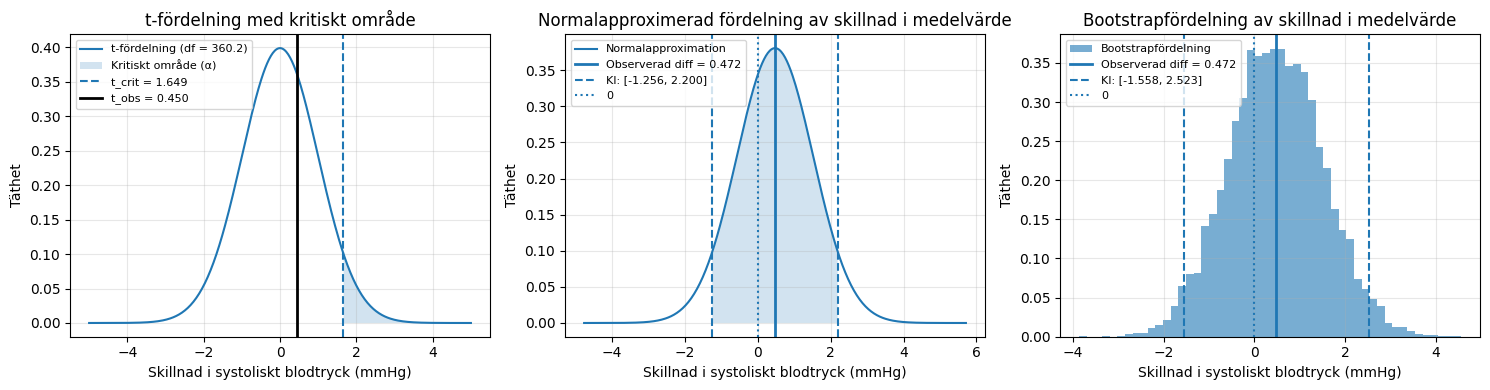

In [7]:
# Application and visualization of bootstrap and Welch’s t-test for mean difference

#Bootstrap 
def plot_bootstrap_dist(boot_diffs, obs_diff, ci,  p_boot=None, xlabel="Skillnad (grupp1 − grupp2)"):
    ci_low, ci_high = ci
    
    fig, ax = plt.subplots(figsize=(7,4))
    ax.hist(boot_diffs, bins=50, density=True, alpha=0.6, label="Bootstrapfördelning")
    
    # Observed difference
    ax.axvline(obs_diff, linewidth=2, label=f'Observerad diff = {obs_diff:.3f}')

    # Confidence interval
    ax.axvline(ci_low, linestyle='--', label=f"KI: ({ci_low:.3f}, {ci_high:.3f})")
    ax.axvline(ci_high, linestyle='--')
    
    # Zero difference (for intuition)
    ax.axvline(0, linestyle=':', label='0')

    ax.set_title("Bootstrapfördelning av skillnad i medelvärde")
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Täthet")
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


def plot_t_distribution(t_stat, dof, confidence=0.95, two_sided=False):
    """
    Plottar t-fördelningen med markerat kritiskt område och observerat t-värde.
    two_sided=False = ensidigt test (H1: diff > 0).
    """

    alpha = 1 - confidence
    
    # Determine critical t depending on one-sided/two-sided test
    if two_sided:
        t_crit = t_dist.ppf(1 - alpha/2, dof)
        crit_left = -t_crit
        crit_right = t_crit
    else:
        t_crit = t_dist.ppf(1 - alpha, dof)
        crit_left = None
        crit_right = t_crit

    # x-axis
    xs = np.linspace(-5, 5, 1000)
    ys = t_dist.pdf(xs, dof)

    fig, ax = plt.subplots(figsize=(7,4))
    ax.plot(xs, ys, label=f"t-fördelning (df = {dof:.1f})")

    # Shade the critical region
    if two_sided:
        ax.fill_between(xs, 0, ys, where=(xs <= crit_left), alpha=0.2, label="Kritiskt område (α/2)")
        ax.fill_between(xs, 0, ys, where=(xs >= crit_right), alpha=0.2)
    else:
        ax.fill_between(xs, 0, ys, where=(xs >= crit_right), alpha=0.2, label="Kritiskt område (α)")
    
    # Mark the critical t-value
    if two_sided:
        ax.axvline(crit_left, linestyle='--', label=f"−t_crit = {crit_left:.3f}")
    ax.axvline(crit_right, linestyle='--', label=f"t_crit = {t_crit:.3f}")

    # Mark the observed t-value
    ax.axvline(t_stat, linewidth=2, label=f"t_obs = {t_stat:.3f}", color="black")

    # Graph settings
    title = "t-fördelning med kritiskt område (ensidigt test)" if not two_sided else "t-fördelning med kritiskt område (tvåsidigt test)"
    ax.set_title(title)
    ax.set_xlabel("t-värde")
    ax.set_ylabel("Täthet")
    ax.grid(alpha=0.3)
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


def plot_mean_diff_normal(diff, se, ci, xlabel="Skillnad (grupp1 − grupp2)"):
    """
    Visualizes the normal approximation of the difference in means.
    'diff' = observed difference.
    'se'   = standard error of the difference.
    'ci'   = (ci_low, ci_high) from your test.
    """
    
    ci_low, ci_high = ci

    # Create x-axis around diff
    xs = np.linspace(diff - 5*se, diff + 5*se, 400)
    ys = (1/(np.sqrt(2*np.pi)*se)) * np.exp(-(xs - diff)**2 / (2*se**2))

    plt.figure(figsize=(7,4))
    plt.plot(xs, ys, label="Normalapproximation")
    
    # Observed difference
    plt.axvline(diff, linewidth=2, label=f"Observerad diff = {diff:.3f}")

    # Confidence interval
    plt.axvline(ci_low, linestyle='--', label=f"KI: ({ci_low:.3f}, {ci_high:.3f})")
    plt.axvline(ci_high, linestyle='--')
    plt.fill_between(xs, 0, ys, where=(xs>=ci_low)&(xs<=ci_high), alpha=0.2)

    # Zero difference
    plt.axvline(0, linestyle=':', label="0")

    plt.title("Normalapproximerad fördelning av skillnad i medelvärde")
    plt.xlabel(xlabel)
    plt.ylabel("Täthet")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot the functions for Systolic bp
smoker_yes = df.loc[df["smoker"] == "Yes", "systolic_bp"]
smoker_no = df.loc[df["smoker"] == "No", "systolic_bp"]

obs_diff, p_boot, (ci_low_b, ci_high_b), boot_diffs = bootstrap_mean_diff(
    smoker_yes, smoker_no,
    confidence=0.95,
    n_boot=10_000,
    two_sided=False  # Tests only whether smokers have higher blood pressure
)

diff, p_value, (ci_low_wt, ci_high_wt), t_stat, dof, se = welch_t_test_mean_diff(
    smoker_yes, smoker_no,
    confidence=0.95,
    two_sided=False  # Expecting smokers > non-smokers
)

# Display of results table
res_tests = pd.DataFrame({
    "Metod": ["Bootstrap", "Welch t-test"],
    "Observerad skillnad": [obs_diff, diff],
    "p-värde": [p_boot, p_value],
    "KI nedre": [ci_low_b, ci_low_wt],
    "KI övre": [ci_high_b, ci_high_wt]
}).round(3)

display(
    res_tests.style
    .set_caption("Jämförelse mellan bootstrap och Welch’s t-test")
    .format({
        "Observerad skillnad": "{:.3f}",
        "p-värde": "{:.3f}",
        "KI nedre": "{:.3f}",
        "KI övre": "{:.3f}"
    })
    .set_table_styles([
        {"selector": "caption",
         "props": [("caption-side", "top"), ("font-weight", "bold"), ("font-size", "110%")]},
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]}
    ])
)

ffig, axes = plt.subplots(1, 3, figsize=(15, 4))

# --- 1️⃣ t-fördelning ---
alpha = 0.05
t_crit = t_dist.ppf(1 - alpha, dof)
xs = np.linspace(-5, 5, 400)
ys = t_dist.pdf(xs, dof)
axes[0].plot(xs, ys, label=f"t-fördelning (df = {dof:.1f})")
axes[0].fill_between(xs, 0, ys, where=(xs >= t_crit), alpha=0.2, label="Kritiskt område (α)")
axes[0].axvline(t_crit, ls='--', label=f"t_crit = {t_crit:.3f}")
axes[0].axvline(t_stat, color="black", lw=2, label=f"t_obs = {t_stat:.3f}")
axes[0].set_title("t-fördelning med kritiskt område")
axes[0].set_xlabel("Skillnad i systoliskt blodtryck (mmHg)")
axes[0].set_ylabel("Täthet")
axes[0].grid(alpha=0.3)
axes[0].legend(loc="upper left", fontsize=8)

# --- 2️⃣ Normalapproximation ---
xs = np.linspace(diff - 5*se, diff + 5*se, 400)
ys = (1/(np.sqrt(2*np.pi)*se)) * np.exp(-(xs - diff)**2 / (2*se**2))
axes[1].plot(xs, ys, label="Normalapproximation")
axes[1].axvline(diff, lw=2, label=f"Observerad diff = {diff:.3f}")
axes[1].axvline(ci_low_wt, ls='--')
axes[1].axvline(ci_high_wt, ls='--', label=f"KI: [{ci_low_wt:.3f}, {ci_high_wt:.3f}]")
axes[1].axvline(0, ls=':', label='0')
axes[1].fill_between(xs, 0, ys, where=(xs >= ci_low_wt) & (xs <= ci_high_wt), alpha=0.2)
axes[1].set_title("Normalapproximerad fördelning av skillnad i medelvärde")
axes[1].set_xlabel("Skillnad i systoliskt blodtryck (mmHg)")
axes[1].set_ylabel("Täthet")
axes[1].grid(alpha=0.3)
axes[1].legend(loc="upper left", fontsize=8)

# --- 3️⃣ Bootstrapfördelning ---
axes[2].hist(boot_diffs, bins=50, density=True, alpha=0.6, label="Bootstrapfördelning")
axes[2].axvline(obs_diff, lw=2, label=f"Observerad diff = {obs_diff:.3f}")
axes[2].axvline(ci_low_b, ls='--')
axes[2].axvline(ci_high_b, ls='--', label=f"KI: [{ci_low_b:.3f}, {ci_high_b:.3f}]")
axes[2].axvline(0, ls=':', label="0")
axes[2].set_title("Bootstrapfördelning av skillnad i medelvärde")
axes[2].set_xlabel("Skillnad i systoliskt blodtryck (mmHg)")
axes[2].set_ylabel("Täthet")
axes[2].grid(alpha=0.3)
axes[2].legend(loc="upper left", fontsize=8)

plt.tight_layout()
plt.show()

# plot_t_distribution(t_stat, dof, confidence = 0.95, two_sided=False )
# plot_mean_diff_normal(diff, se, (ci_low_wt, ci_high_wt), xlabel="Skillnad i systoliskt blodtryck (mmHg)")
# plot_bootstrap_dist(boot_diffs, obs_diff, (ci_low_b, ci_high_b), p_boot=p_boot, xlabel="Skillnad i systoliskt blodtryck (mmHg)")



### Tolkning

Både bootstrapmetoden och Welch’s t-test ger mycket liknande resultat för skillnaden i medelvärde av systoliskt blodtryck mellan rökare och icke-rökare.
Den observerade skillnaden är liten (≈ 0,47 mmHg), och båda metoderna ger konfidensintervall som inkluderar noll.
Detta innebär att ingen statistiskt säkerställd skillnad påvisas vid 95 % konfidensnivå.

De tre graferna visar också symmetriska fördelningar kring noll, vilket tyder på att normalitetsantagandet är rimligt och att resultaten från båda metoderna är stabila.

P-värdena (0,50 för bootstrap och 0,33 för Welch’s t-test) ligger långt över den vedertagna signifikansgränsen på 0,05. Nollhypotesen kan därför inte förkastas, vilket innebär att resultaten inte tyder på någon verklig skillnad i systoliskt blodtryck mellan rökare och icke-rökare.


Sammantaget visar både bootstrapmetoden och Welch’s t-test att eventuella skillnader i systoliskt blodtryck mellan rökare och icke-rökare sannolikt beror på slumpmässig variation snarare än en verklig effekt.

## Kontrollera hur säkert hypotestestet är, hittar en skillnad när den finns (power)

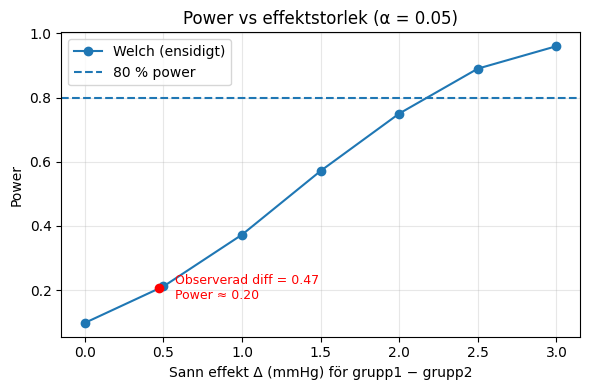

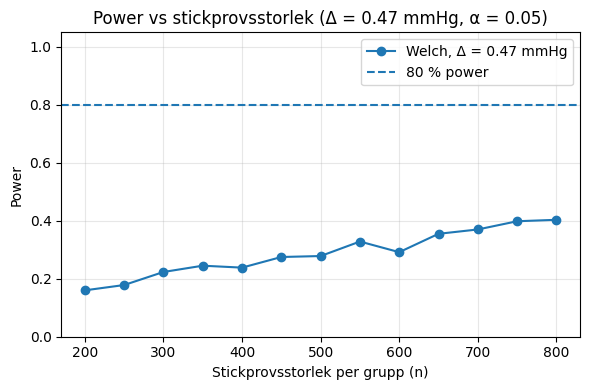

In [12]:
def simulate_power_welch(
    group1, group2,
    effect=1.0,           # sann skillnad i medel: group1 - group2 (mmHg)
    n1=None, n2=None,     # stickprovsstorlekar; None = behåll nuvarande storlekar
    trials=1000,
    alpha=0.05,
    one_sided=True,
    random_state=42
):
    """
    Power = andelen simuleringar där p < alpha givet sann effekt 'effect'.
    Bevarar form/spridning via resampling av centrerade data och skiftar medel i group1 med 'effect'.
    Test: Welch's t-test (equal_var=False).
    """
    rng = np.random.default_rng(random_state)

    x1 = np.asarray(group1, float); x1 = x1[~np.isnan(x1)]
    x2 = np.asarray(group2, float); x2 = x2[~np.isnan(x2)]

    # centrera för att bevara form/spridning
    x1c = x1 - x1.mean()
    x2c = x2 - x2.mean()

    if n1 is None: n1 = len(x1)
    if n2 is None: n2 = len(x2)

    hits = 0
    for _ in range(trials):
        # resampla och skifta group1 med 'effect'
        s1 = rng.choice(x1c, size=n1, replace=True) + x1.mean() + effect
        s2 = rng.choice(x2c, size=n2, replace=True) + x2.mean()

        t_stat, p_two = ttest_ind(s1, s2, equal_var=False)

        if one_sided:
            # H1: mean(group1) > mean(group2)  (justera tecken vid behov)
            p = p_two/2 if t_stat > 0 else 1 - p_two/2
        else:
            p = p_two

        hits += (p < alpha)

    return hits / trials


# Anta att du redan har:
smoker_yes = df.loc[df["smoker"] == "Yes", "systolic_bp"]
smoker_no  = df.loc[df["smoker"] == "No",  "systolic_bp"]

effects = np.arange(0.0, 3.1, 0.5)  # 0–3 mmHg i steg om 0.5
power_welch = [
    simulate_power_welch(smoker_yes, smoker_no, effect=d,
                         trials=800, alpha=0.05, one_sided=True)
    for d in effects
]


pd.DataFrame({"Δ (mmHg)": effects, "Power (Welch, ensidigt)": np.round(power_welch, 3)})


plt.figure(figsize=(6,4))
plt.plot(effects, power_welch, marker="o", label="Welch (ensidigt)")
plt.axhline(0.80, linestyle="--", label="80 % power")
power_obs = np.interp(obs_diff, effects, power_welch)
plt.scatter(obs_diff, power_obs, color="red", zorder=5)
plt.text(obs_diff + 0.1, power_obs, f"Observerad diff = {obs_diff:.2f}\nPower ≈ {power_obs:.2f}",
         color="red", fontsize=9, va="center")

plt.title("Power vs effektstorlek (α = 0.05)")
plt.xlabel("Sann effekt Δ (mmHg) för grupp1 − grupp2")
plt.ylabel("Power")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# --- Power som funktion av stickprovsstorlek (n per grupp) för vald Δ ---
import numpy as np
import matplotlib.pyplot as plt

effect_chosen = obs_diff              # välj en kliniskt relevant skillnad (mmHg)
ns = np.arange(200, 801, 50)      # 20, 40, ..., 200 per grupp

power_n = [
    simulate_power_welch(
        smoker_yes, smoker_no,
        effect=effect_chosen,
        n1=n, n2=n,
        trials=600, alpha=0.05, one_sided=True
    )
    for n in ns
]

target = 0.80
if np.max(power_n) >= target:
    n_at_80 = float(np.interp(target, power_n, ns))
else:
    n_at_80 = None

# --- Markera ungefärligt n för 80% power (om möjligt) ---
target_power = 0.80
power_values = np.array(power_n)
sample_sizes = np.array(ns)
n_at_80 = None
if power_values.max() >= target_power:
    n_at_80 = float(np.interp(target_power, power_values, sample_sizes))

# --- Plot ---
plt.figure(figsize=(6,4))
plt.plot(sample_sizes, power_values, "o-", label=f"Welch, Δ = {effect_chosen:.2f} mmHg")
plt.axhline(target_power, linestyle="--", label="80 % power")

if n_at_80 is not None:
    plt.scatter(n_at_80, target_power, color="red", zorder=5)
    plt.text(n_at_80 + 5, target_power, f"≈ {int(round(n_at_80))} obs./grupp\nför 80 % power",
             color="red", fontsize=9, va="center")

plt.title(f"Power vs stickprovsstorlek (Δ = {effect_chosen:.2f} mmHg, α = 0.05)")
plt.xlabel("Stickprovsstorlek per grupp (n)")
plt.ylabel("Power")
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


### Tolkning av power-test
En simulering av testets power visar att sannolikheten att upptäcka en verklig skillnad beror både på effektens storlek och stickprovsstorleken.
Vid små skillnader i systoliskt blodtryck (< 1 mmHg) är power låg, vilket innebär att testet sällan hittar någon signifikant skillnad även om en liten effekt finns.
För en skillnad på cirka 2–3 mmHg ökar power betydligt, särskilt vid större stickprov.
Resultaten visar att det nuvarande urvalet är för litet för att med hög säkerhet upptäcka små skillnader mellan rökare och icke-rökare — testets power ligger under 80 %.
Det innebär att nollhypotesen mycket väl kan ha behållits på grund av otillräcklig teststyrka snarare än frånvaro av verklig effekt.

Den observerade skillnaden mellan rökare och icke-rökare var cirka 0,47 mmHg.
En simulering av testets power visar att vid denna effektstorlek ligger teststyrkan på endast omkring 20 %.
Detta innebär att sannolikheten att upptäcka en så liten verklig skillnad är låg givet det aktuella urvalet.
Att ingen statistiskt säkerställd skillnad påvisades kan därför delvis bero på låg teststyrka snarare än frånvaro av en faktisk effekt.

Figuren visar sambandet mellan stickprovsstorlek och power (testets styrka) vid den observerade effekten på Δ = 0,47 mmHg.
Power förblir låg även vid stora stickprov, och når inte 80 % ens vid 800 individer per grupp.

Detta innebär att sannolikheten att upptäcka en verklig skillnad av denna storlek är liten med det aktuella testet.
Resultatet förklarar varför hypotesprövningen inte visade någon signifikant skillnad — effekten är helt enkelt för liten för att kunna upptäckas med rimlig säkerhet givet urvalets storlek.